In [1]:
%%capture installation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [17]:
class Args:
    batch_size = 1
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "cnn_256"

args = Args()

In [18]:
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, valid_dataloader, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader {config['dataset_name']}!!!!!") 

Working on the dataset: cifar10!!!!!


/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/harsh/Documents/projects/Semantic-Preserving-Adversarial-Attack/models/autoencoder.py:844: UnderReviewWarning: The feature AE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  super().__init__(input_height=inpu

Loaded classifier and autoencoder models in eval mode!!!!!
Files already downloaded and verified
Files already downloaded and verified
Loaded dataloader cifar10!!!!!


In [19]:
def plot_adversarial_images(images, pgd_adv_images, spgd_adv_images, reshape_size=(28, 28)):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,5,1, xticks=[], yticks=[])
    plt.title("Original")
    plt.imshow(images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    plt.subplot(1,5,2, xticks=[], yticks=[])
    plt.title("PGD")
    plt.imshow(pgd_adv_images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    pgd_noise = pgd_adv_images[0] - images[0]
    plt.subplot(1,5,3, xticks=[], yticks=[])
    plt.title("PGD Noise")
    plt.imshow(pgd_noise.cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    plt.subplot(1,5,4, xticks=[], yticks=[])
    plt.title("SemanticPGD")
    plt.imshow(spgd_adv_images[0].cpu().detach().reshape(reshape_size).permute(1, 2, 0))

    spgd_noise = spgd_adv_images[0] - images[0]
    plt.subplot(1,5,5, xticks=[], yticks=[])
    plt.title("SemanticPGD Noise")
    plt.imshow(spgd_noise.cpu().detach().reshape(reshape_size).permute(1, 2, 0))

In [20]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :  
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # Perturb original image
        adv_images = images + alpha*images.grad.sign()

        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

def semantic_pgd_attack(model, ae_model, images, labels, eps=0.4, alpha=8/255, s_alpha=0.007, iters=100, batch_size=1) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    adv_images = images.clone().detach()
    original_inputs_numpy = images.clone().cpu().detach().numpy()
        
    for i in range(iters) :
        adv_images.requires_grad = True
        # adv_images = adv_images.to(args.device)
        
        # Classifier part
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # # Perturb original image
        # adv_images = images + alpha*images.grad.sign()

        # # Adjust semantics
        # adv_images = adv_images.detach_()
        # adv_images.requires_grad = True
        # recon_images, _ = ae_model(adv_images)
        # ae_model.zero_grad()

        # Calculate grad w.r.t classifier
        grad_classifier = adv_images.grad.cpu().detach()

        # Autoencoder part
        adv_images.grad = None
        recon_images, _ = ae_model(adv_images)
        ae_model.zero_grad()

        mse_loss = F.mse_loss(adv_images, recon_images).to(args.device)
        mse_loss.backward()

        # Calculate grad w.r.t autoencoder
        grad_autoencoder = adv_images.grad.cpu().detach()

        # Check if the attack is successful
        has_attack_succeeded = (outputs.cpu().detach().numpy().argmax(1)!=labels.cpu().numpy())

        # Calculate the projection of perceptual grad on classifier
        # and grad_autoencoder = grad_autoencoder - (projection of gradient_autoencoder onto gradient_classifier)
        grad_autoencoder_proj = grad_autoencoder - torch.bmm((torch.bmm(grad_autoencoder.view(batch_size, 1, -1), 
                                grad_classifier.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_classifier.view(batch_size, 1, -1),
                                grad_classifier.view(batch_size, -1, 1))).view(-1, 1, 1),
                                grad_classifier.view(batch_size, 1, -1)).view(grad_autoencoder.shape)

        # Calculate the projection of classifier grad on autoencoder
        # and grad_classifier = grad_classifier - (projection of gradient_classifier onto gradient_autoencoder)
        grad_classifier_proj = grad_classifier - torch.bmm((torch.bmm(grad_classifier.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_autoencoder.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1))).view(-1, 1, 1),
                               grad_autoencoder.view(batch_size, 1, -1)).view(grad_classifier.shape)

        # Combine grads (Selective Gradient Descent)
        # grad = grad_classifier * (1-has_attack_succeeded) - grad_autoencoder * has_attack_succeeded
        grad = grad_classifier_proj * (1-has_attack_succeeded) - (grad_autoencoder_proj) * has_attack_succeeded

        # Add semantic perturbation
        # adv_examples = adv_images - s_alpha * sign_data_grad

        # Apply combined perturbation
        sign_grad = torch.sign(grad).to(torch.float32).to(args.device)
        adv_images = adv_images.detach() + alpha * sign_grad

        eta = torch.clamp(adv_images - torch.tensor(original_inputs_numpy).to(args.device), min=-eps, max=eps)
        adv_images = torch.clamp(torch.tensor(original_inputs_numpy).to(args.device) + eta, min=0, max=1).detach()
            
    return adv_images

In [21]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

def lpips_pgd_attack(model, ae_model, images, labels, eps=0.4, alpha=8/255, s_alpha=0.007, iters=100, batch_size=1) :
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    adv_images = images.clone().detach()
    original_inputs_numpy = images.clone().cpu().detach().numpy()
        
    for i in range(iters) :
        adv_images.requires_grad = True
        # adv_images = adv_images.to(args.device)
        
        # Classifier part
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # # Perturb original image
        # adv_images = images + alpha*images.grad.sign()

        # # Adjust semantics
        # adv_images = adv_images.detach_()
        # adv_images.requires_grad = True
        # recon_images, _ = ae_model(adv_images)
        # ae_model.zero_grad()

        # Calculate grad w.r.t classifier
        grad_classifier = adv_images.grad.cpu().detach()

        # LPIPS part
        adv_images.grad = None
        lpips_loss = lpips(images, adv_images)
        # recon_images, _ = ae_model(adv_images)
        # ae_model.zero_grad()

        # mse_loss = F.mse_loss(adv_images, recon_images).to(args.device)
        lpips_loss.backward()
        # mse_loss.backward()

        # Calculate grad w.r.t autoencoder
        grad_autoencoder = adv_images.grad.cpu().detach()

        # Check if the attack is successful
        has_attack_succeeded = (outputs.cpu().detach().numpy().argmax(1)!=labels.cpu().numpy())

        # Calculate the projection of perceptual grad on classifier
        # and grad_autoencoder = grad_autoencoder - (projection of gradient_autoencoder onto gradient_classifier)
        grad_autoencoder_proj = grad_autoencoder - torch.bmm((torch.bmm(grad_autoencoder.view(batch_size, 1, -1), 
                                grad_classifier.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_classifier.view(batch_size, 1, -1),
                                grad_classifier.view(batch_size, -1, 1))).view(-1, 1, 1),
                                grad_classifier.view(batch_size, 1, -1)).view(grad_autoencoder.shape)

        # Calculate the projection of classifier grad on autoencoder
        # and grad_classifier = grad_classifier - (projection of gradient_classifier onto gradient_autoencoder)
        grad_classifier_proj = grad_classifier - torch.bmm((torch.bmm(grad_classifier.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1)))/(1e-20+torch.bmm(grad_autoencoder.view(batch_size, 1, -1),
                               grad_autoencoder.view(batch_size, -1, 1))).view(-1, 1, 1),
                               grad_autoencoder.view(batch_size, 1, -1)).view(grad_classifier.shape)

        # Combine grads (Selective Gradient Descent)
        # grad = grad_classifier * (1-has_attack_succeeded) - grad_autoencoder * has_attack_succeeded
        grad = grad_classifier_proj * (1-has_attack_succeeded) - (grad_autoencoder_proj) * has_attack_succeeded

        # Add semantic perturbation
        # adv_examples = adv_images - s_alpha * sign_data_grad

        # Apply combined perturbation
        sign_grad = torch.sign(grad).to(torch.float32).to(args.device)
        adv_images = adv_images.detach() + alpha * sign_grad

        eta = torch.clamp(adv_images - torch.tensor(original_inputs_numpy).to(args.device), min=-eps, max=eps)
        adv_images = torch.clamp(torch.tensor(original_inputs_numpy).to(args.device) + eta, min=0, max=1).detach()
            
    return adv_images

Length of validation dataloader: 10000
0 iterations done!!
10 iterations done!!
20 iterations done!!
30 iterations done!!
40 iterations done!!
50 iterations done!!
60 iterations done!!
70 iterations done!!
80 iterations done!!
90 iterations done!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([101, 3, 32, 32]) torch.Size([101, 3, 32, 32])
Accuracy of test pgd : 0.990099 %
Accuracy of test spgd: 7.920792 %


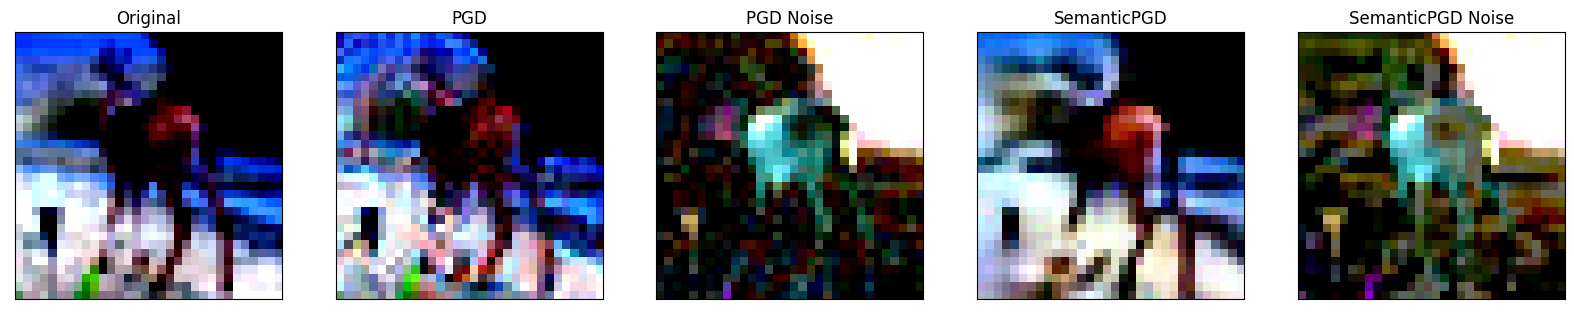

In [22]:
pgd_correct = 0
spgd_correct = 0
total = 0

pgd = []
spgd = []
print(f"Length of validation dataloader: {len(test_dataloader)}")

for i, (images, labels) in enumerate(test_dataloader):
    labels = labels.to(args.device)
    images = images.to(args.device)

    pgd_adv_images = pgd_attack(classifier_model, images, labels)
    spgd_adv_images = semantic_pgd_attack(classifier_model, autoencoder_model, images, labels)
    # print(type(pgd_adv_images), type(spgd_adv_images))
    # print(pgd_adv_images.shape, spgd_adv_images.shape)
    pgd.append(pgd_adv_images)
    spgd.append(spgd_adv_images)

    pgd_outputs = classifier_model(pgd_adv_images)
    spgd_outputs = classifier_model(spgd_adv_images)
    
    _, pgd_pre = torch.max(pgd_outputs.data, 1)
    _, spgd_pre = torch.max(spgd_outputs.data, 1)

    total += 1
    pgd_correct += (pgd_pre == labels).sum()
    spgd_correct += (spgd_pre == labels).sum()
    if i == 100:
        break
    if i % 10 == 0:
        print(f"{i} iterations done!!")
    
    # plt.imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

pgd = torch.stack(pgd).reshape((-1, 3, 32, 32))
spgd = torch.stack(spgd).reshape((-1, 3, 32, 32))
print(pgd.shape, spgd.shape)

print('Accuracy of test pgd : %f %%' % (100 * float(pgd_correct) / (total)))
print('Accuracy of test spgd: %f %%' % (100 * float(spgd_correct) / (total)))

plot_adversarial_images(images, pgd_adv_images, spgd_adv_images, reshape_size=(3, 32, 32))

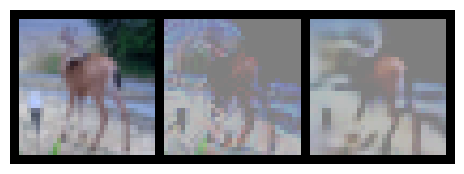

In [23]:
import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

images = images.cpu().detach()
pgd_adv_images = pgd_adv_images.cpu().detach()
spgd_adv_images = spgd_adv_images.cpu().detach()

plot_images(torch.stack([images, pgd_adv_images, spgd_adv_images]))

##### LPIPS

In [25]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img_orig = torch.Tensor(pgd_adv_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img_modf = torch.Tensor(spgd_adv_images)
img = images.detach().cpu()

orig_lpips = loss_fn_alex(img, img_orig)
modf_lpips = loss_fn_alex(img, img_modf)
print("Average LPIPS score of original adversarial attack: ", orig_lpips.flatten().mean())
print("Average LPIPS score of modifed adversarial attack: ", modf_lpips.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/harsh/anaconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS score of original adversarial attack:  tensor(0.1316, grad_fn=<MeanBackward0>)
Average LPIPS score of modifed adversarial attack:  tensor(0.1256, grad_fn=<MeanBackward0>)


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
